In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import plotly.express as px
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('sysmonlogs.csv')
df.columns, df.shape

(Index(['IP', 'computer_name', 'Image'], dtype='object'), (14527, 3))

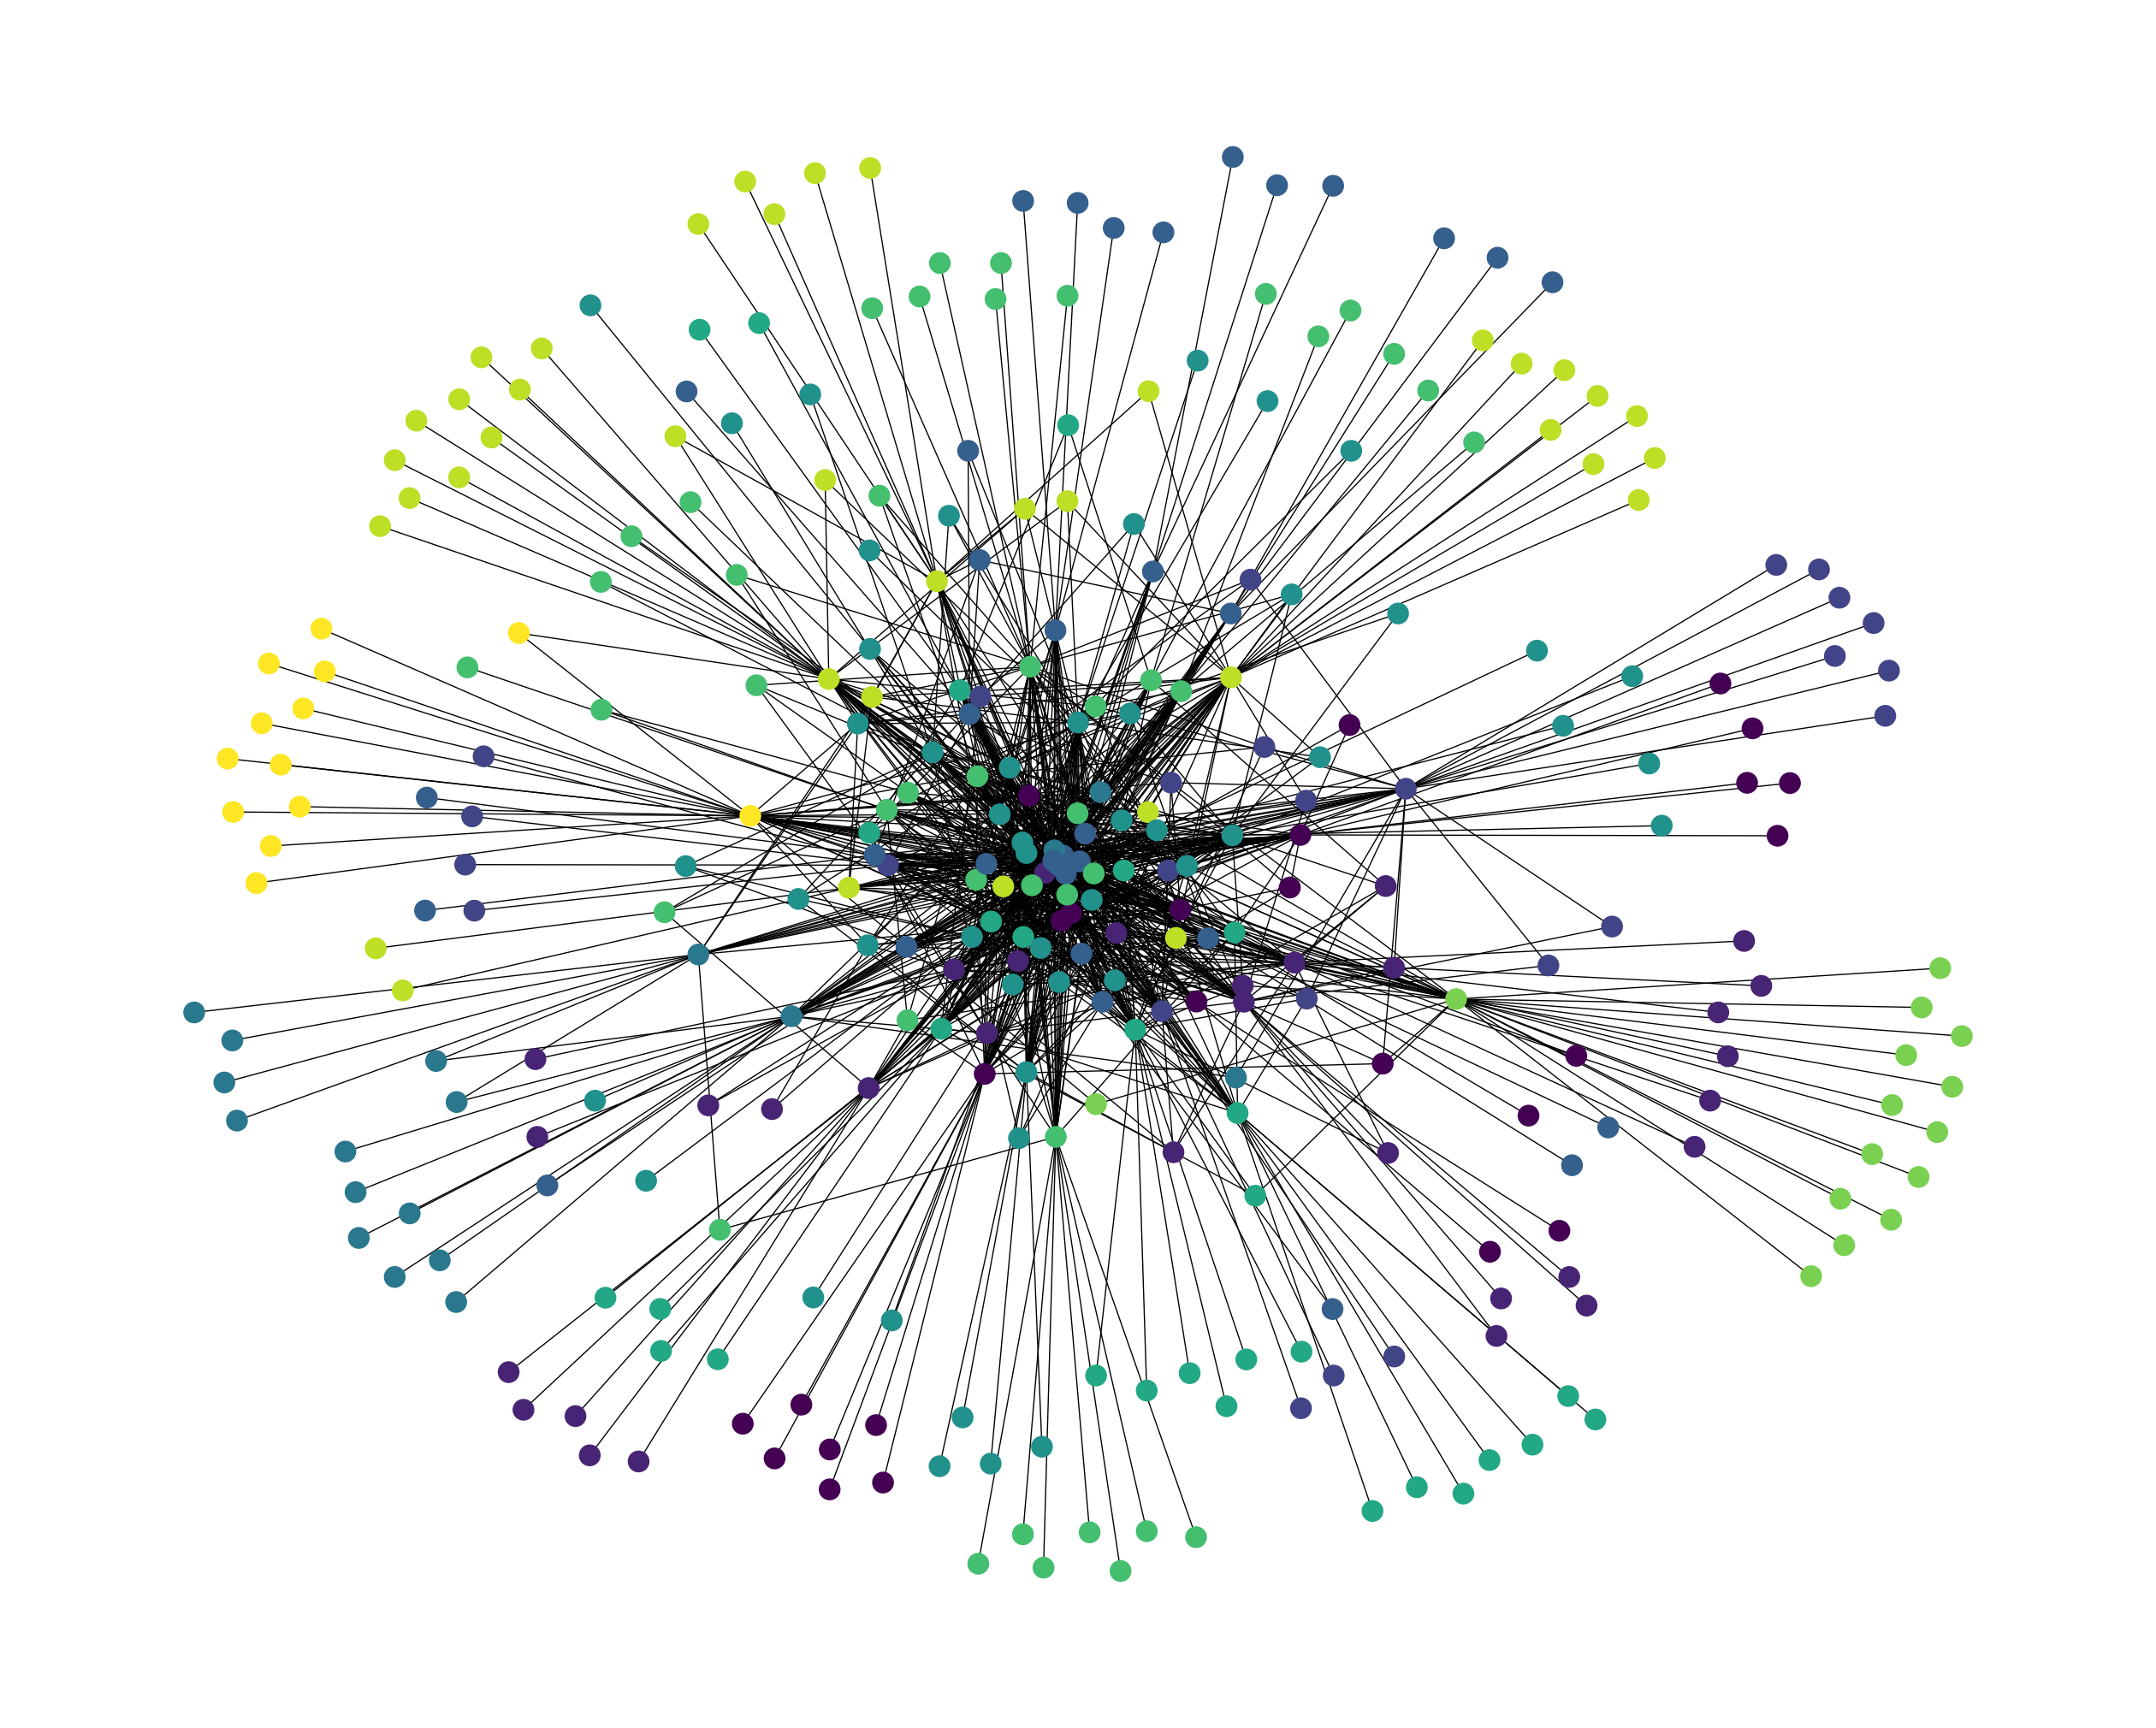

In [7]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'computer_name','Image')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

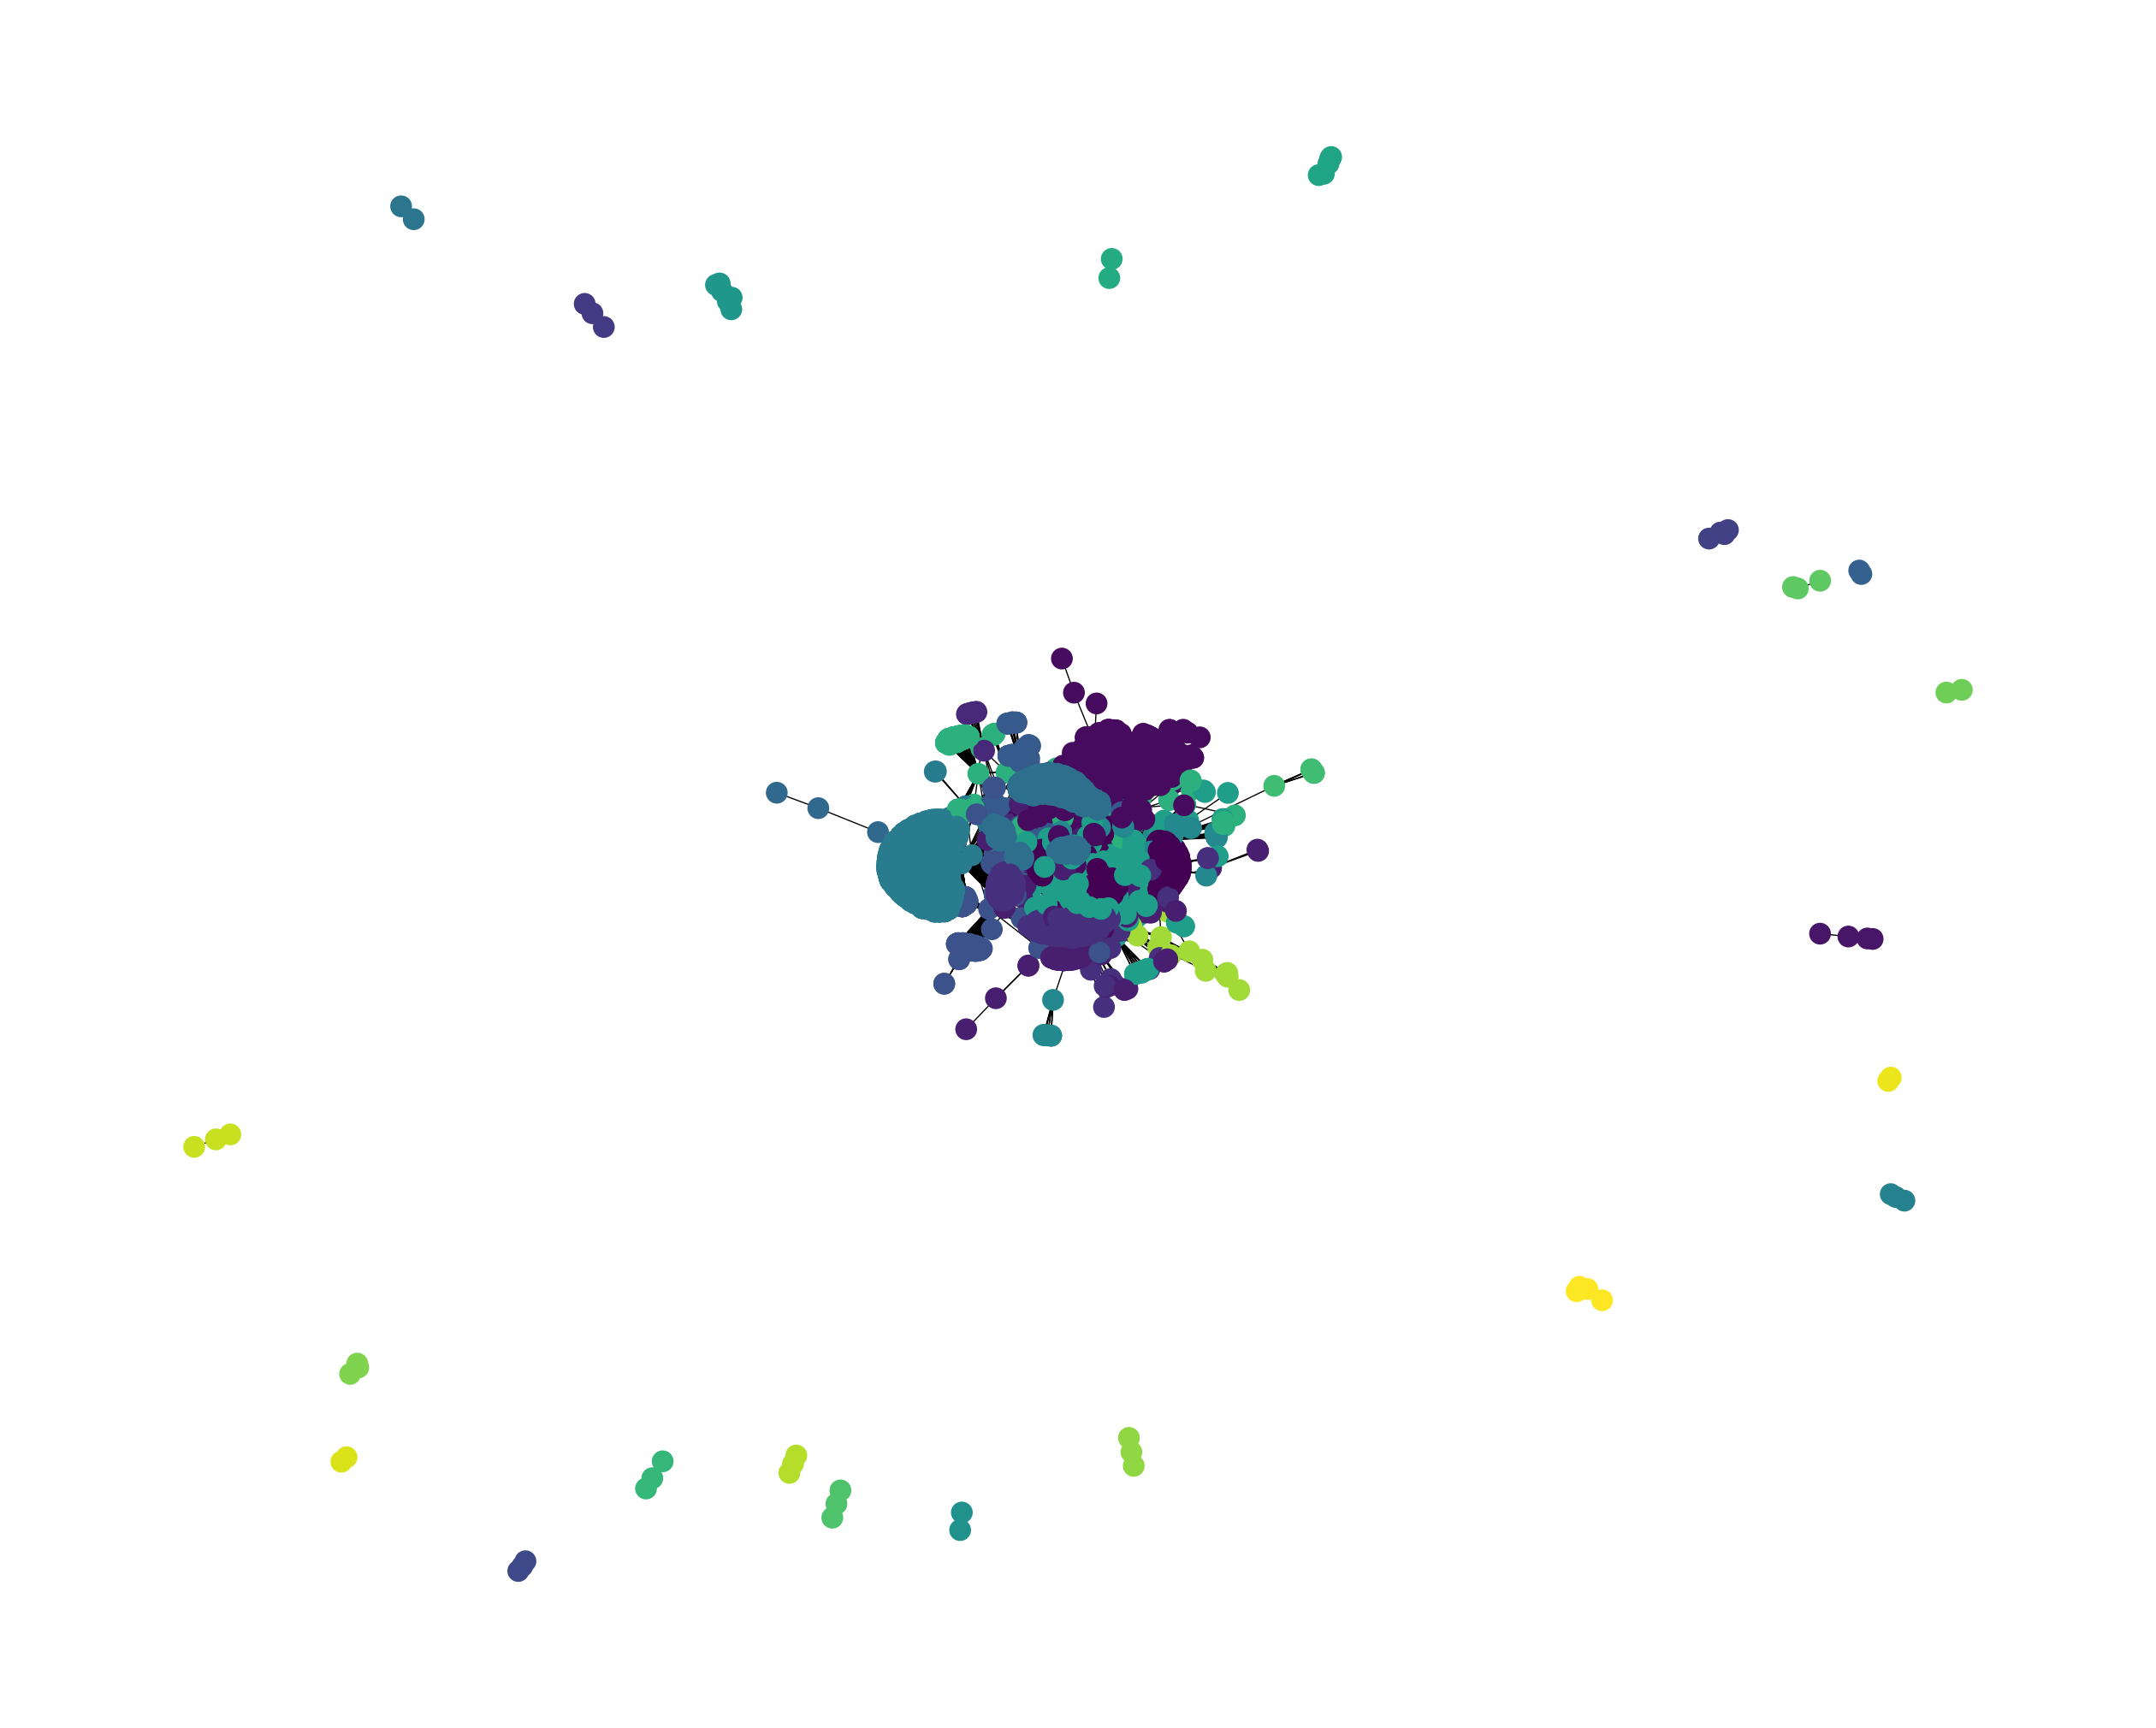

In [9]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'Image','IP')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

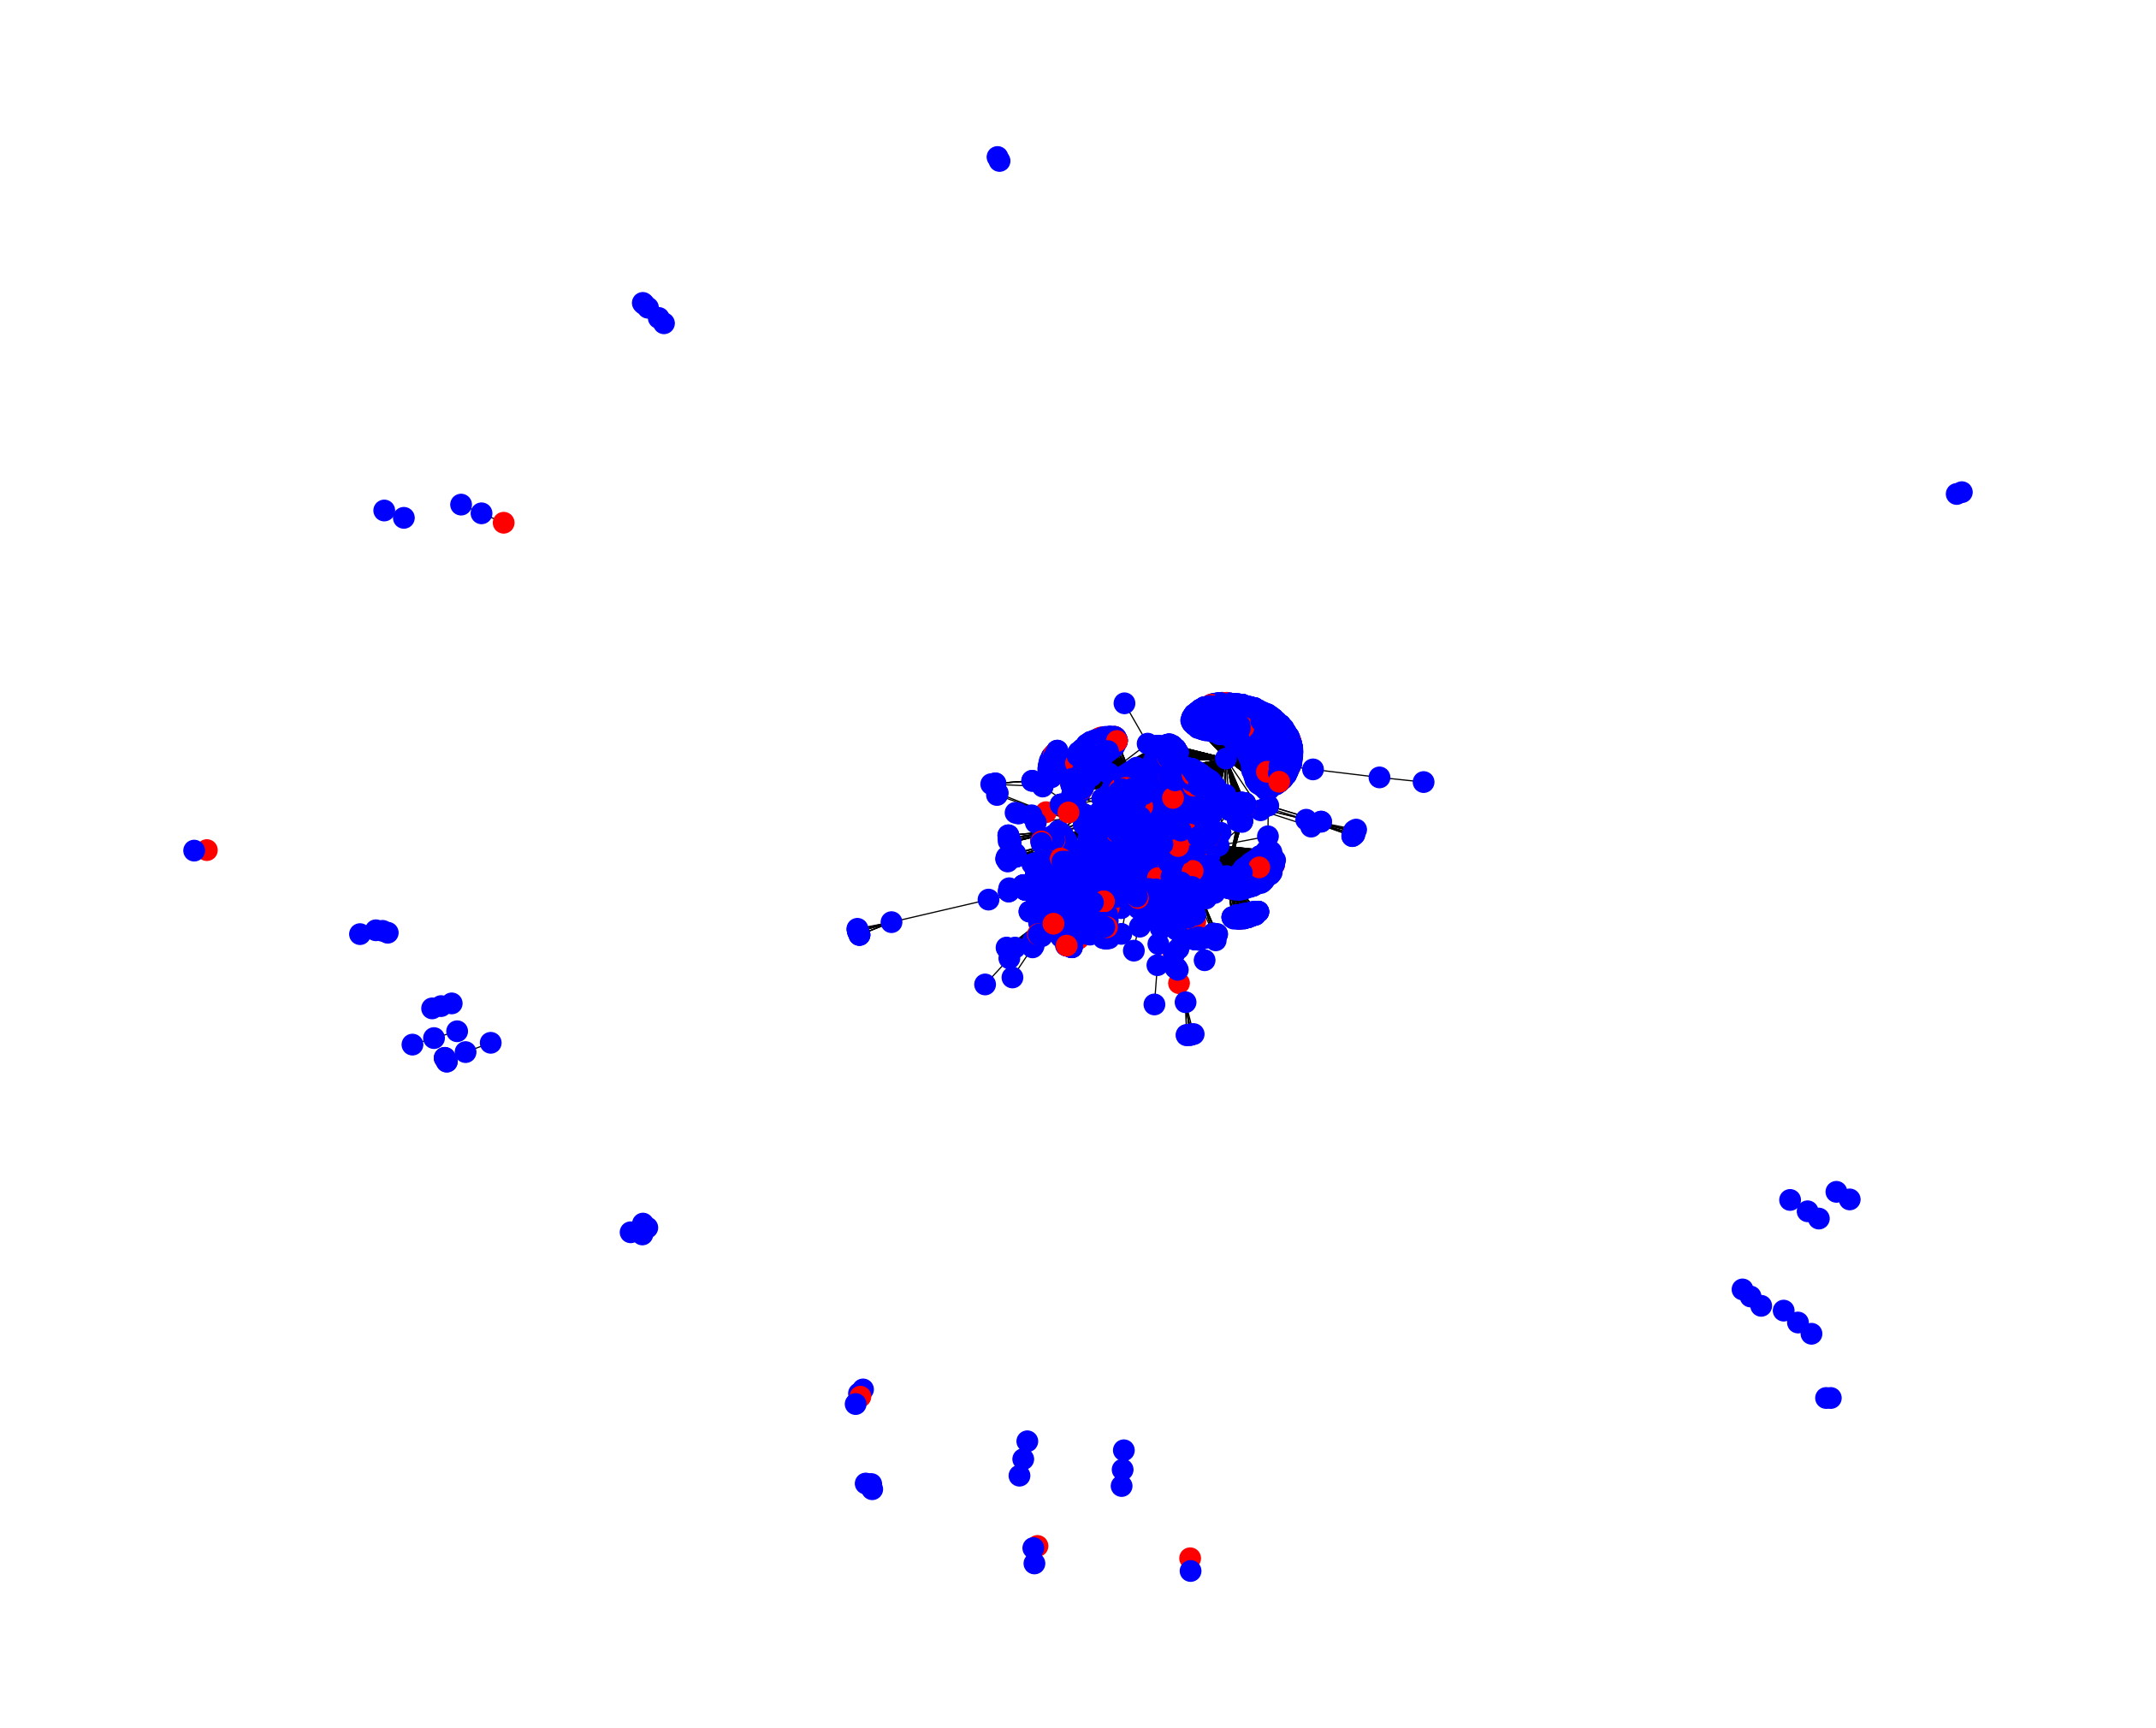

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

le = LabelEncoder()
df['IP_encoded'] = le.fit_transform(df['IP'])
df['Image_encoded'] = le.fit_transform(df['Image'])

node_features = df[['IP_encoded', 'Image_encoded']]

# Train Isolation Forest
clf = IsolationForest(contamination=0.05)
pred = clf.fit_predict(node_features)

# Add anomaly information to the partition dictionary
for i, node in enumerate(G.nodes()):
    part[node] = pred[i] + 1 

anomaly_color = ['red' if pred[i] == -1 else 'blue' for i in range(len(G.nodes()))]

# Visualize the graph with anomaly color
figure(figsize=(25, 20))
nx.draw_spring(G, node_color=anomaly_color, with_labels=False)


List of Outliers (Image, IP):
[('C:\\Windows\\System32\\svchost.exe', '172.16.26.226'), ('C:\\Windows\\System32\\svchost.exe', '13.89.178.27'), ('C:\\Program Files\\WindowsApps\\91750D7E.Slack_4.37.101.0_x64__8she8kybcnzg4\\app\\Slack.exe', '99.77.145.43'), ('C:\\Program Files\\WinlogBeat\\winlogbeat.exe', '99.79.100.155'), ('C:\\Windows\\System32\\svchost.exe', '192.168.1.1'), ('C:\\Windows\\System32\\svchost.exe', '209.148.170.203'), ('C:\\Windows\\System32\\svchost.exe', '192.168.32.14'), ('<unknown process>', '3.161.213.59'), ('C:\\Windows\\System32\\svchost.exe', '192.168.242.1'), ('C:\\Windows\\System32\\svchost.exe', '208.38.43.211'), ('C:\\Users\\SrihariKannanThiruma\\AppData\\Local\\slack\\app-4.38.115\\slack.exe', '13.127.99.68'), ('<unknown process>', '18.67.17.30'), ('C:\\Windows\\System32\\svchost.exe', '208.38.43.169'), ('C:\\Windows\\System32\\svchost.exe', '172.176.48.21'), ('C:\\Program Files\\Mozilla Firefox\\firefox.exe', '74.125.34.46'), ('C:\\Users\\Chaitanya.sonku

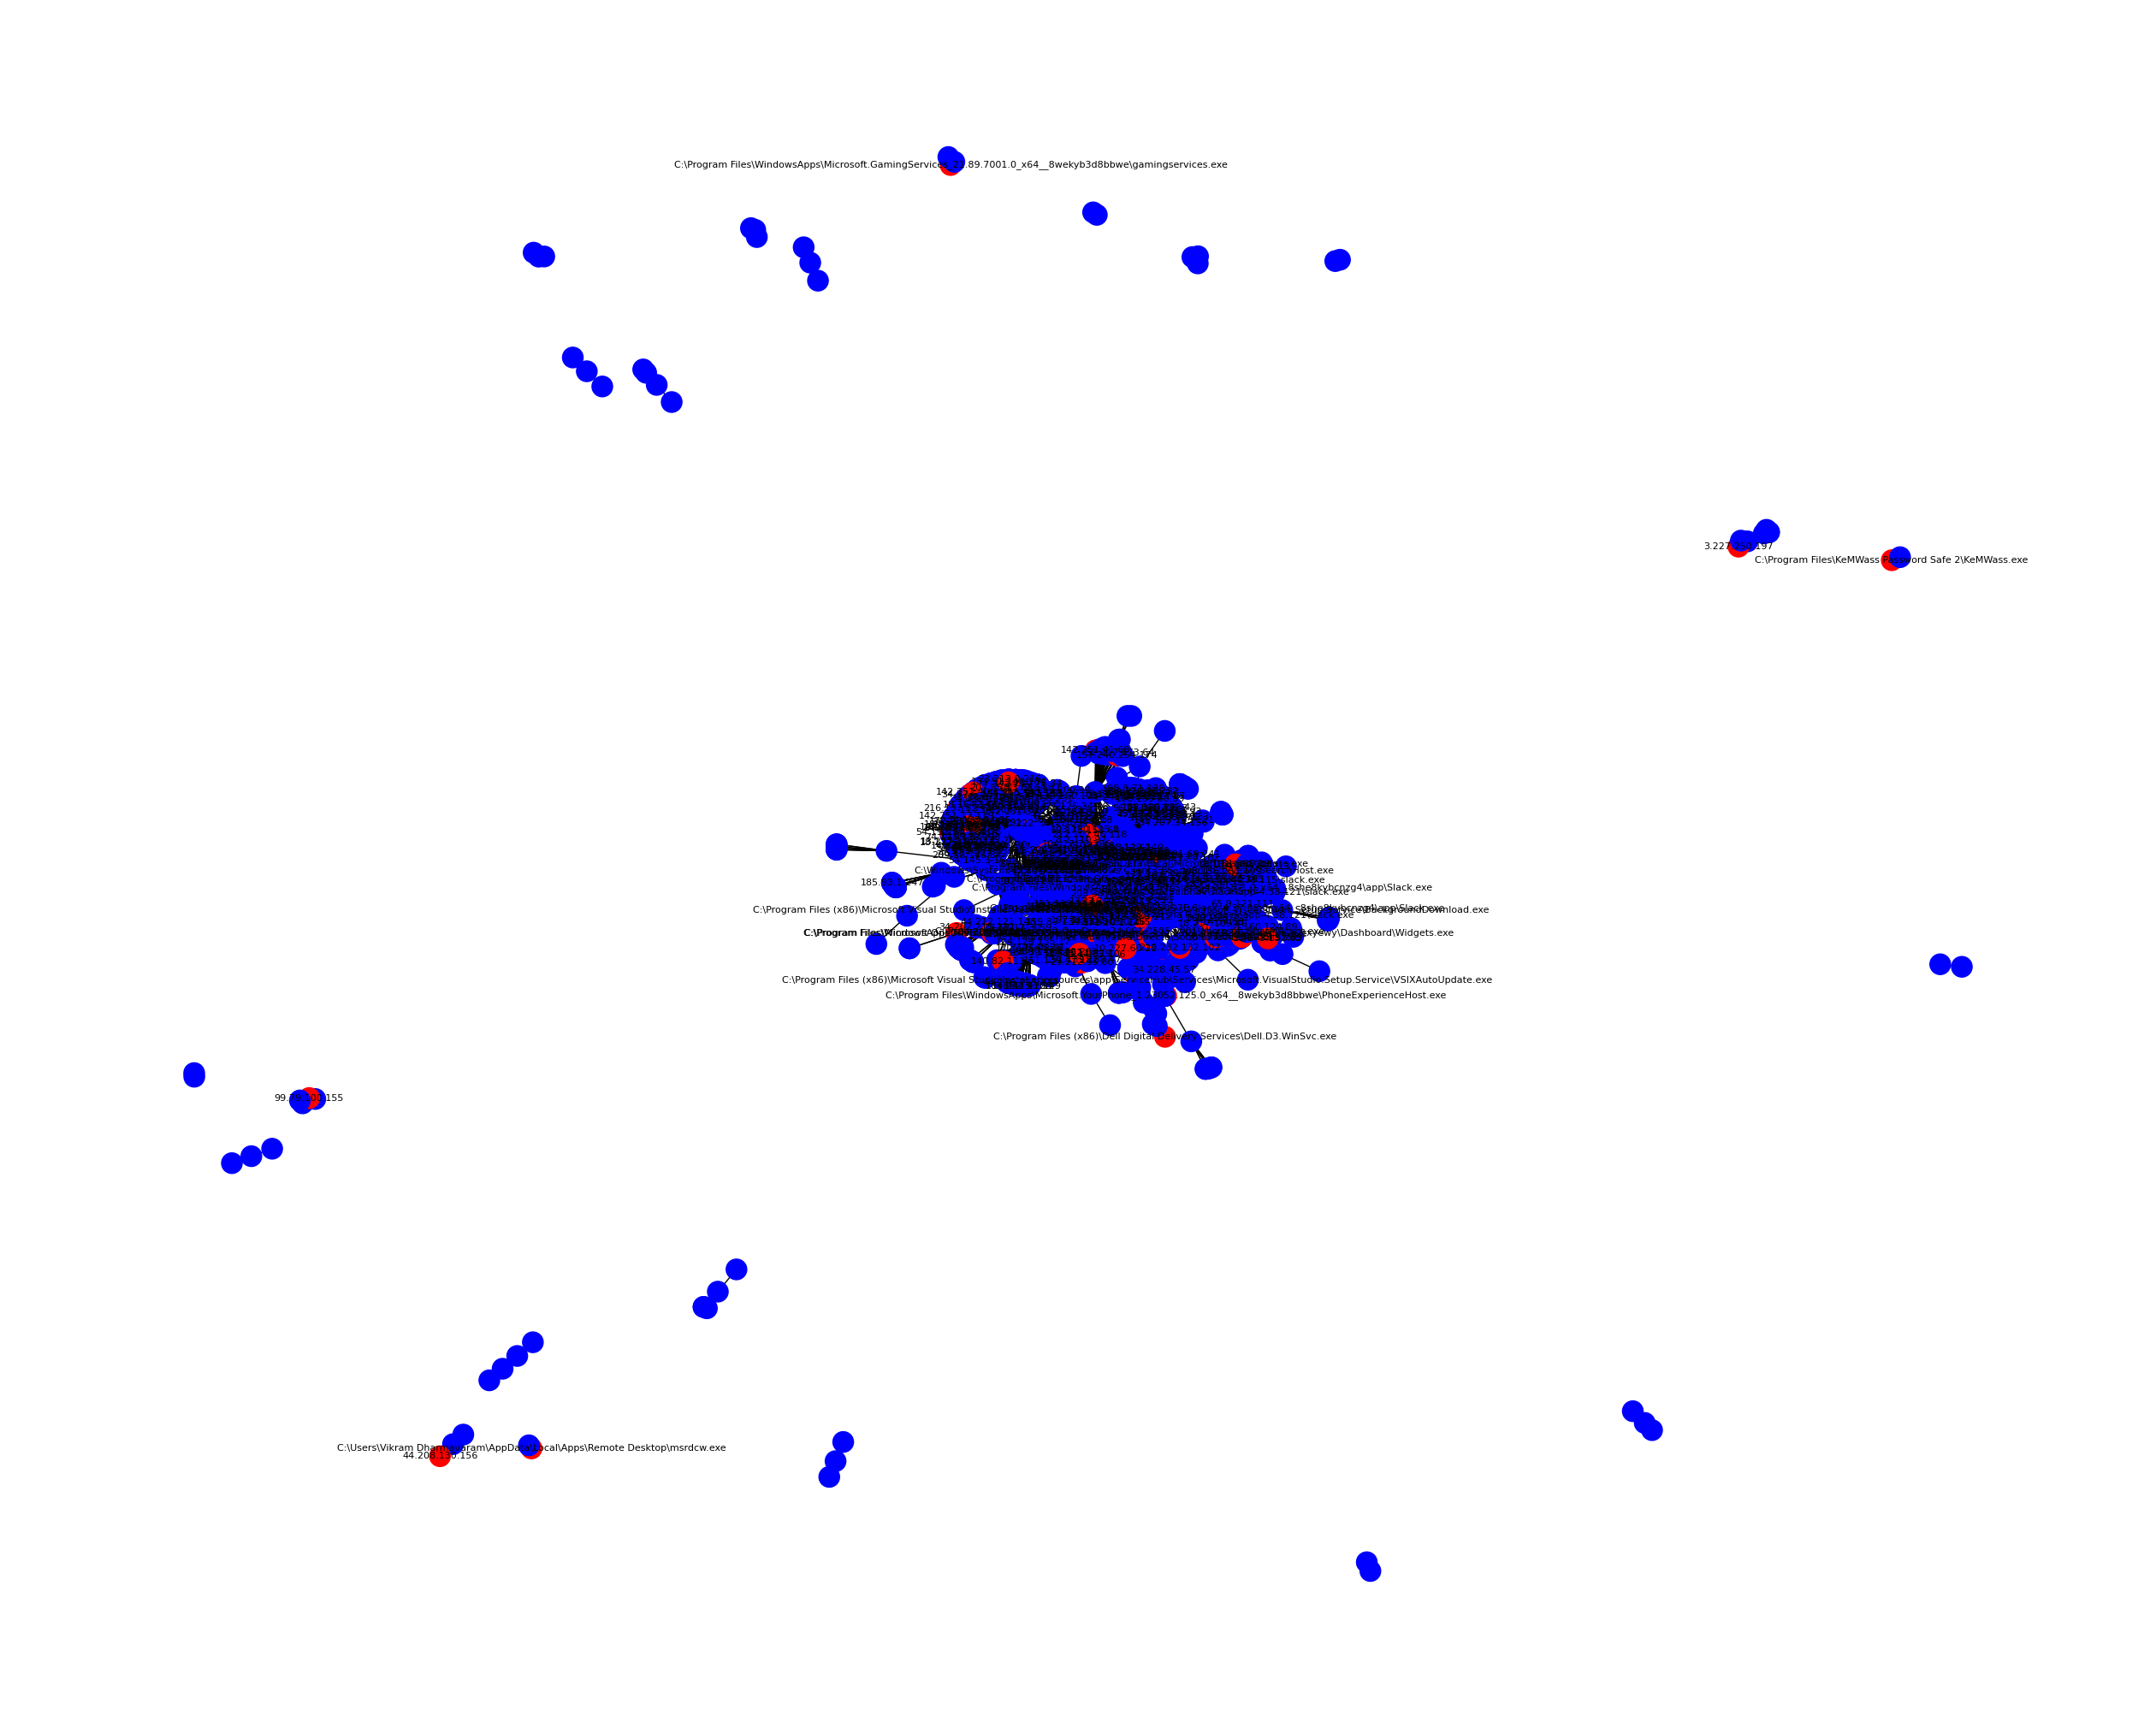

In [12]:
import matplotlib.pyplot as plt

anomaly_threshold = 95

anomalies = [node for node, score in zip(G.nodes(), clf.decision_function(node_features)) if score < anomaly_threshold]

node_labels = {node: node if node in anomalies else '' for node in G.nodes()}

# Visualize the graph with labeled anomalies
figure(figsize=(25, 20))
nx.draw_spring(G, node_color=anomaly_color, labels=node_labels, font_size=8)

outliers_list = [(df.loc[df['IP'] == node, 'Image'].values[0] if len(df.loc[df['IP'] == node, 'Image']) > 0 else None, node) for node in anomalies]

outliers_list = [(image, ip) for image, ip in outliers_list if image is not None]

print("List of Outliers (Image, IP):")
print(outliers_list, "\n")

plt.show()